1. https://aws.amazon.com/blogs/machine-learning/evaluating-an-automatic-speech-recognition-service/

In [56]:
import jiwer
import re
import pandas as pd
from termcolor import colored
from diff_match_patch import diff_match_patch
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [16]:
def print_pairs(list1, list2):
    for t1, t2 in zip(list1, list2):
        print(colored(t1, 'red'), '\n', t2)
        print('-'*10)

In [17]:
def process_common_voice(texts:'List'):
    texts=[re.search('(?<=mp3\t).*', x).group().split('\t')[0] for x in texts]
    return texts

def process_bluejeans(texts):
    texts = ''.join(texts).split()
    texts = ' '.join(texts)
    utterances = [texts]
    #utterances = re.findall('(?<=\d{3}\n).*(?=\n\n\d)', texts)
    return utterances
    
def process_meets(texts):
    # skip first 10 lines as they are just for introduction
    texts = ''.join(texts[10:])
    utterances = re.findall('(?<=:\n).*(?=\n\n\n)',texts)
    return utterances

def process_zoom(texts):
    texts = ''.join(texts)
    utterances=re.findall('(?<=:\d\d\s).*(?=\n\d)',texts)
    return utterances

def process_cisco(texts):
    texts = ''.join(texts)
    utterances=re.findall('(?<=\d\n).*(?=\n\n)', texts)
    return utterances

In [18]:
def get_dmp_pattern(text, pattern):
    CLIP = 50
    dmp=diff_match_patch()
    start = dmp.match_bitap(text, pattern[:CLIP], 0)
    end = dmp.match_bitap(text[::-1], pattern[::-1][:CLIP], 0)
    return start, end

### Nov 21

In [19]:
import os
sorted_paths=sorted(os.listdir('./transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/'))
sorted_paths=[os.path.join('./transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/', path) for path in sorted_paths]

In [20]:
sorted_paths

['./transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/AlGore_2006.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/AmandaPalmer_2013.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/BoydVarty_2013W.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/BrendaBrathwaite_2011X.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/CarlSafina_2010X.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/CarolDweck_2014X.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/DanPacholke_2014X.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/DilipRatha_2014G.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/EleniGabreMadhin_2007G.stm',
 './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ground_truth/ElifShafak_2010

In [21]:
def clean_gt(text):
    text = text.replace('<unk>',' ')
    text = re.sub('( )+', ' ', text)
    return text

def parse_gt(lines):
    lines = map(lambda x: x.split('<NA>')[1].strip(), lines)
    text = ' '.join(lines)
    text = clean_gt(text)
    return text

In [22]:
gt_texts = []
for path in sorted_paths:
    lines = open(path).readlines()
    text = parse_gt(lines)
    gt_texts.append(text)

In [123]:
def get_dmp_pattern(text, pattern):
    dmp=diff_match_patch()
    start = dmp.match_bitap(text, pattern, 0)
    return start

def print_zipped(zipped):
    print(colored(zipped[0], 'red'))
    print(colored(zipped[1], 'green')) 

def check_similarity(text, pattern):
    index = get_dmp_pattern(text, pattern)
    if index!=(-1):
        return True
    
    pattern = re.sub('[^a-zA-Z0-9]', '', pattern.lower())
    text = re.sub('[^a-zA-Z0-9]', '', text.lower())
    if text in pattern:
        return True

def get_jiwer_score(t1, t2):
    wer = jiwer.wer(t1, t2)
    mer = jiwer.mer(t1, t2)
    wil = jiwer.wil(t1, t2)
    
    return wer, mer, wil

def is_valid_sent(sentence):
    if len(sentence.split())<=2:
        return False
        
    return True

In [24]:
df_speaker = pd.read_csv('./transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/ats-audio-speaker-data.csv')
df_speaker['Filename'] = df_speaker['Audio File'].apply(lambda x: x.split('.')[0])
df_speaker.drop(['Audio File'], axis=1, inplace=True)

In [25]:
ATS = {
        'meets':(process_meets, './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/google_meet_ted_talk.txt'),
        'zoom':(process_zoom, './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/zoom_ted_talk.txt'),
        'cisco':(process_cisco, './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/cisco_webex_ted_talk.vtt'),
        'bluejeans':(process_bluejeans, './transcript_files_12_1_sans_bluejeans2/transcript_files_12_1/bluejeans_ted_talk.txt')
      }

In [148]:
df = pd.DataFrame(columns=['Filename'])
filenames = [os.path.split(x)[-1].split('.')[0] for x in sorted_paths]
df['Filename'] = pd.Series(filenames)
chunks_final = {}

for ats in ATS:
    func, path = ATS[ats]
    processed = func(open(path).readlines())
    processed_merged = ' '.join(processed)
    sentences = processed_merged.split('.')
    
    wers, mers, wils = [], [], []
    chunks=[]
    sent_iter = -1
    last_end = -1

    for i, gt in enumerate(gt_texts):
        start, end = None, None # start and end are the sentence numbers
        pattern_start, pattern_end = gt[:50], gt[-50:]
        print('\n', i, colored(os.path.split(sorted_paths[i])[-1], attrs=['bold']))
        print('start string\t', colored(pattern_start,'red'))
        print('end string\t', colored(pattern_end, 'green'))

        while sent_iter < len(sentences)-1:
            sent_iter+=1

            if not is_valid_sent(sentences[sent_iter]):
                continue

            if start is None:
                start = check_similarity(sentences[sent_iter], pattern_start)
                start = sent_iter if start else None
                if start is not None:
                    print('start\t', colored(start, 'red'))

            if start is not None:
                end = check_similarity(sentences[sent_iter][::-1], pattern_end[::-1])
                end = sent_iter if end else None
                if end is not None:
                    chunks.append('. '.join(sentences[start:end+1]))

                    # adding the metrics for current ground truth
                    wer, mer, wil = get_jiwer_score(gt, chunks[-1])
                    wers.append(wer)
                    mers.append(mer)
                    wils.append(wil)

                    # updating last_end
                    last_end = end

                    print('end\t', colored(end, 'red'))
                    break     
        else:
            # the end was not found for current ground truth
            # for next ground truth, start from last_end
            sent_iter = last_end

            # add empty string anyways for consistency
            chunks.append('')

            # add dummy row corresponding to this ground truth
            wers.append('NA')
            mers.append('NA')
            wils.append('NA')
            
        
    df[f'Wer_{ats}'] = pd.Series(wers)
#     df[f'Mer_{ats}'] = pd.Series(mers)
#     df[f'Wil_{ats}'] = pd.Series(wils)
    
    chunks_final[ats] = chunks
    
df_final = pd.merge(df_speaker, df, on=['Filename'])


 0 AlGore_2006.stm
start string	  it 's truly a great honor to have the opportunity
end string	 coherence to them we are one thank you very much i
start	 2
end	 164

 1 AmandaPalmer_2013.stm
start string	  i didn 't always make my living from music for ab
end string	  started asking how do we let people pay for music
start	 166
end	 267

 2 BoydVarty_2013W.stm
start string	  trying to live from his heart and so just before 
end string	 what people all over south africa are trying to do
start	 312
end	 477

 3 BrendaBrathwaite_2011X.stm
start string	  when we think of games there 's all kinds of thin
end string	 and we 're playing and we 're learning as we do so
start	 480
end	 608

 4 CarlSafina_2010X.stm
start string	  this is the ocean as i used to know it and i find
end string	 's a matter of right and wrong thank you very much
start	 610
end	 611

 5 CarolDweck_2014X.stm
start string	  i heard about a high school in chicago where stud
end string	 children to live in places that cr

end	 122

 1 AmandaPalmer_2013.stm
start string	  i didn 't always make my living from music for ab
end string	  started asking how do we let people pay for music
start	 124
end	 208

 2 BoydVarty_2013W.stm
start string	  trying to live from his heart and so just before 
end string	 what people all over south africa are trying to do
start	 242
end	 374

 3 BrendaBrathwaite_2011X.stm
start string	  when we think of games there 's all kinds of thin
end string	 and we 're playing and we 're learning as we do so
start	 376
end	 453

 4 CarlSafina_2010X.stm
start string	  this is the ocean as i used to know it and i find
end string	 's a matter of right and wrong thank you very much
start	 455
end	 458

 5 CarolDweck_2014X.stm
start string	  i heard about a high school in chicago where stud
end string	 children to live in places that create that growth
start	 591
end	 668

 6 DanPacholke_2014X.stm
start string	  the organization that is the bucket for failed so
end string	 e will earn our t

start	 3897
end	 3915

 39 YangLan_2011G.stm
start string	  the night before i was heading for scotland i was
end string	 e being transformed themselves thank you very much
start	 3968
end	 4068

 40 ZeynepTufekci_2014G.stm
start string	  so recently we heard a lot about how social media
end string	 self are not going to be enough over the long term
start	 4070
end	 4074

 0 AlGore_2006.stm
start string	  it 's truly a great honor to have the opportunity
end string	 coherence to them we are one thank you very much i
start	 2
end	 172

 1 AmandaPalmer_2013.stm
start string	  i didn 't always make my living from music for ab
end string	  started asking how do we let people pay for music
start	 175
end	 274

 2 BoydVarty_2013W.stm
start string	  trying to live from his heart and so just before 
end string	 what people all over south africa are trying to do
start	 324
end	 494

 3 BrendaBrathwaite_2011X.stm
start string	  when we think of games there 's all kinds of thin
end string	 and we

end	 5177

 38 VikramPatel_2012G.stm
start string	  i want you to imagine this for a moment two men r
end string	 ve the care that we know can transform their lives
start	 5324
end	 5350

 39 YangLan_2011G.stm
start string	  the night before i was heading for scotland i was
end string	 e being transformed themselves thank you very much
start	 5422
end	 5564

 40 ZeynepTufekci_2014G.stm
start string	  so recently we heard a lot about how social media
end string	 self are not going to be enough over the long term
start	 5567
end	 5663

 0 AlGore_2006.stm
start string	  it 's truly a great honor to have the opportunity
end string	 coherence to them we are one thank you very much i
start	 0
end	 140

 1 AmandaPalmer_2013.stm
start string	  i didn 't always make my living from music for ab
end string	  started asking how do we let people pay for music
start	 142
end	 228

 2 BoydVarty_2013W.stm
start string	  trying to live from his heart and so just before 
end string	 what people all over

end	 4363

 38 VikramPatel_2012G.stm
start string	  i want you to imagine this for a moment two men r
end string	 ve the care that we know can transform their lives
start	 4470
end	 4495

 39 YangLan_2011G.stm
start string	  the night before i was heading for scotland i was
end string	 e being transformed themselves thank you very much
start	 4551
end	 4666

 40 ZeynepTufekci_2014G.stm
start string	  so recently we heard a lot about how social media
end string	 self are not going to be enough over the long term
start	 4668
end	 4737


In [134]:
import numpy as np

In [136]:
df_final.replace('NA', np.nan, inplace=True)

In [142]:
df_final.dropna(inplace=True)

In [147]:
df_final.loc[:, df_final.columns!='Filename'].reset_index()

,index,Speaker,Gender,Age,Born/From,Wer_meets,Wer_zoom,Wer_cisco,Wer_bluejeans
0,0,Al Gore,M,58.0,"Washington, DC, USA",0.383092,0.342029,0.388889,0.359420
1,1,Amanda Palmer,F,37.0,"New York, NY, USA",0.568050,0.543353,0.571729,0.542302
2,3,Brenda Brathwaite,F,45.0,"Ogdensburg, NY",0.441803,0.385835,0.443289,0.437345
3,4,Carl Safina,M,55.0,"Brooklyn, NY",0.983508,0.983508,0.985411,1.816683
4,22,Lucianne Walkowicz,F,36.0,"New York, NY, USA",0.241031,0.233184,0.233184,0.211883


In [150]:
df_final.to_csv('Results.csv')

In [152]:
df_temp = df_final.dropna(subset = ["Gender", 'Wer_meets'])
df_temp = df_temp[(df_temp['Wer_meets']!='NA')&(df_temp['Wer_zoom']!='NA')&(df_temp['Wer_cisco']!='NA')]
df_temp = df_temp[df_temp['Wer_meets']<0.8]

([<matplotlib.axis.XTick at 0x7fbd388bd370>,
 [Text(1, 0, 'Female (n=10)'), Text(2, 0, 'Male (n=8)')])

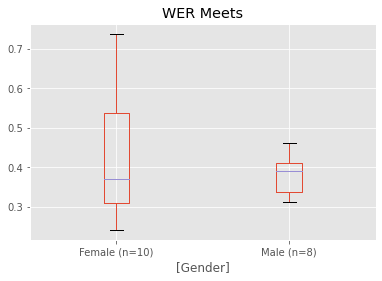

In [160]:
df_temp.boxplot(column=['Wer_meets'], by=['Gender']);
plt.title('WER Meets')
plt.suptitle('')
plt.xticks(ticks=[1,2], labels=['Female (n=10)', 'Male (n=8)'])

In [154]:
df_temp['Gender'].value_counts()

F    10
M     8
Name: Gender, dtype: int64

([<matplotlib.axis.XTick at 0x7fbd38837820>,
 [Text(1, 0, 'Female (n=10)'), Text(2, 0, 'Male (n=8)')])

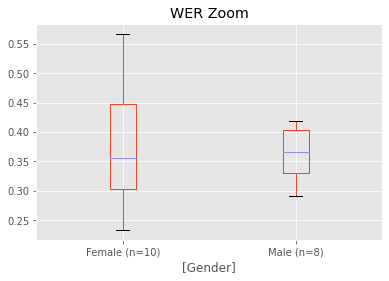

In [161]:
df_temp.boxplot(column=['Wer_zoom'], by=['Gender']);
plt.title('WER Zoom')
plt.suptitle('')
plt.xticks(ticks=[1,2], labels=['Female (n=10)', 'Male (n=8)'])

([<matplotlib.axis.XTick at 0x7fbd387296d0>,
 [Text(1, 0, 'Female (n=10)'), Text(2, 0, 'Male (n=8)')])

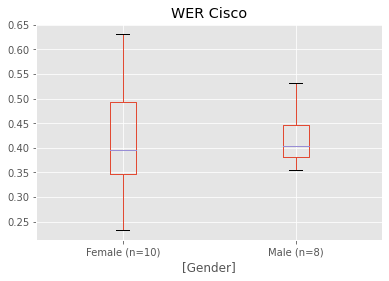

In [164]:
df_temp.boxplot(column=['Wer_cisco'], by=['Gender']);
plt.title('WER Cisco')
plt.suptitle('')
plt.xticks(ticks=[1,2], labels=['Female (n=10)', 'Male (n=8)'])

([<matplotlib.axis.XTick at 0x7fbd385ba2e0>,
 [Text(1, 0, 'Female (n=14)'), Text(2, 0, 'Male (n=9)')])

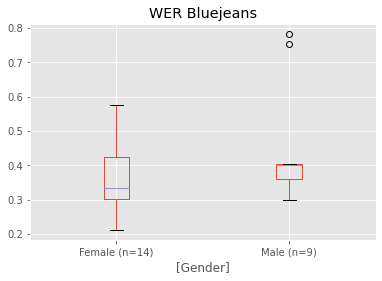

In [167]:
df_temp = df_final.dropna(subset = ["Gender", 'Wer_bluejeans'])
df_temp = df_temp[df_temp['Wer_bluejeans']!='NA']
df_temp = df_temp[df_temp['Wer_bluejeans']<0.8]
df_temp.boxplot(column=['Wer_bluejeans'], by=['Gender']);
plt.title('WER Bluejeans')
plt.suptitle('')
plt.xticks(ticks=[1,2], labels=['Female (n=14)', 'Male (n=9)'])

In [166]:
df_temp['Gender'].value_counts()

F    14
M     9
Name: Gender, dtype: int64

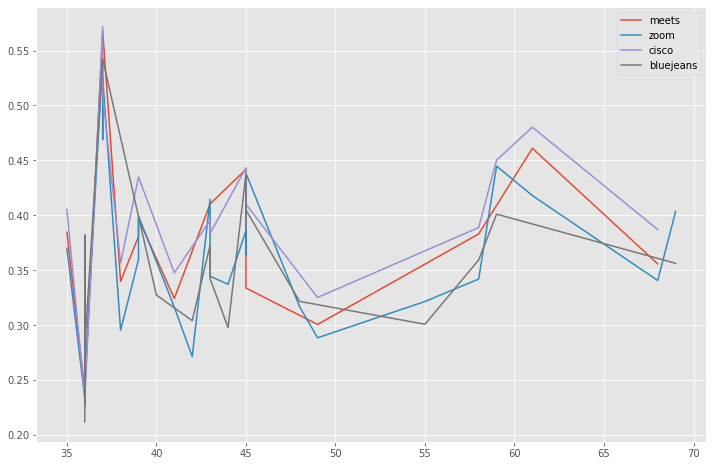

In [151]:
plt.figure(figsize=(12,8))
for ats in ATS:
    df_temp = df_final.dropna(subset = ["Age", f'Wer_{ats}'])
    df_temp = df_temp[df_temp[f'Wer_{ats}']!='NA']
    df_temp = df_temp[df_temp[f'Wer_{ats}']<0.7]
    plt.suptitle('')

    values=df_temp[['Age', f'Wer_{ats}']].values
    values = sorted(values, key=lambda x:x[0])

    x, y = [x[0] for x in values], [x[1] for x in values]
    plt.plot(x,y, label=ats)
plt.legend()

In [94]:
df_temp

,Speaker,Gender,Age,Born/From,Filename,Wer_meets,Wer_zoom,Wer_cisco,Wer_bluejeans
0,Al Gore,M,58.0,"Washington, DC, USA",AlGore_2006,0.383092,0.342029,0.388889,0.35942
1,Amanda Palmer,F,37.0,"New York, NY, USA",AmandaPalmer_2013,0.56805,0.543353,0.571729,0.542302
3,Brenda Brathwaite,F,45.0,"Ogdensburg, NY",BrendaBrathwaite_2011X,0.441803,0.385835,0.443289,0.437345
5,Carol Dweck,F,68.0,"New York, NY, USA",CarolDweck_2014X,0.355847,0.340726,0.387097,NA
10,Fredy Peccerelli,M,43.0,Guatemala,FredyPeccerelli_2014Y,0.410468,0.414601,0.395317,NA
11,Fei-Fei Li,M,39.0,"Beijing, China",FeiFeiLi_2015,0.39698,0.399415,0.434973,NA
12,Gayle Tzemach Lemmon,F,37.0,American (Nationality),GayleTzemachLemmon_2015W,0.73896,0.468977,0.509782,NA
13,Gero Miesenboeck,M,45.0,Austria,GeroMiesenboeck_2010G,0.333872,0.363746,0.410174,NA
15,Halla Tomasdottir,F,41.0,"Reykjavik, Iceland",HallaTomasdottir_2016W,0.324356,0.316436,0.347723,NA
16,Imam Feisal Abdul Rauf,M,61.0,Kuwait,ImamFeisalAbdulRauf_2009P,0.461047,0.418023,0.480233,NA
